# Quantum error correction

In this tutorial, we will discuss basic algorithms for quantum error corrections. These algorithms provide ways to correct qubit errors, since they are very fragile and are prone to errors due to decoherence and other quantum noise. [1],[2]. Those algorithms are  _Bit Flip Code_,  _Phase Flip Code_, and  _Shor Code_ and they will be implemented in Qiskit


[1] https://en.wikipedia.org/wiki/Quantum_error_correction

[2] https://quantumcomputinguk.org/tutorials/quantum-error-correction-phase-flip-code-in-qiskit


In [1]:
import numpy as np
from random import random

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector
from qiskit.circuit import Parameter

### Bit Flip Code

First, we will see how bit flip can be corrected in a quantum circuit. In a quantum computer that means the transition $ |0\rangle \to  |1\rangle$ or vice-versa.

Flipped bits is the error source in both classical and also quantum computing.In the former case, a repeat code suppresses the bit flip error. However, the same approach does not work for a quantum channel. In general, since it is not possible to repeat a single qubit three times (no-cloning theorem), one resorts to another method to overcome this issue. In this case, we apply the three-bit quantum code first proposed by Asher Peres [3]. This technique uses quantum features such as entanglement and resembles the repeat code. 


[3] Peres, Asher (1985). "Reversible Logic and Quantum Computers". Physical Review A. 32 (6): 3266â€“3276.

For the purpose stated earlier, we will implement the _Bit Flip Code_. First, let us generate an intial random state $|\psi\rangle$ for the qubit of interest (qubit 0), which will be considered all over this tutorial

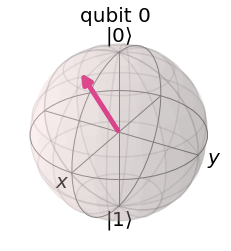

In [2]:
psi = random_statevector(2)
init_gate = Initialize(psi)

plot_bloch_multivector(psi)

Now, we implement the circuit that performs such error correction

In [3]:
num_qubits = 3

qc = QuantumCircuit(num_qubits)

#Random state for Bob
qc.append(init_gate, [0])
qc.barrier()

#Part1: cx gate + hadarmad
for ii in range(num_qubits-1):
    qc.cx(0,ii+1) 

for ii in range(num_qubits):
    qc.h(ii) 
    
qc.barrier()

The bit flip error is implemented through a `Rz` gate applied to first qubit with random angle $\theta_0$

In [4]:
#Part2: bit flp 
theta = random()
aux = QuantumCircuit(num_qubits)

aux.rz(theta,0)
aux.barrier()

The full cirrcuit is

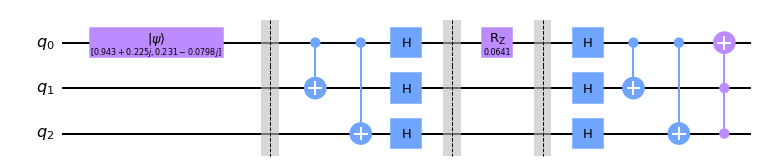

In [5]:
#Part3: hadarmad + cx gate + ccx gate

for ii in range(num_qubits):
    aux.h(ii) 

for ii in range(num_qubits-1):
    aux.cx(0,ii+1)

aux.ccx(2,1,0)

#composing
bit_flip = qc.compose(aux)

bit_flip.draw('mpl')

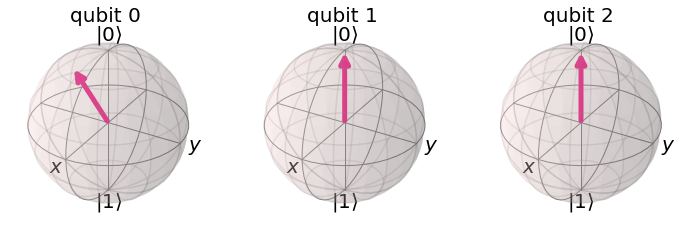

In [6]:
sim = Aer.get_backend('aer_simulator')

bit_flip.save_statevector()
out_vector = sim.run(bit_flip).result().get_statevector()
plot_bloch_multivector(out_vector)

### Phase Flip Code

For quantum computers there is another source of error, which it is the phase flip. That means, through the transmission in a quatnum channel the relative sign between $ |0\rangle $  and $ |1\rangle$ may become inverted. Now, we consider how a phase flip can be corrected by using the _Phase Flip Code_. Let us simulate a phase inversion error by applying a `Rx` gate to the first qubit with random angle $\theta_1$

In [7]:
#Part2: Phase 
theta1 = random()
aux1 = QuantumCircuit(num_qubits)

aux1.rx(theta1,0)
aux1.barrier()

The full cirrcuit is

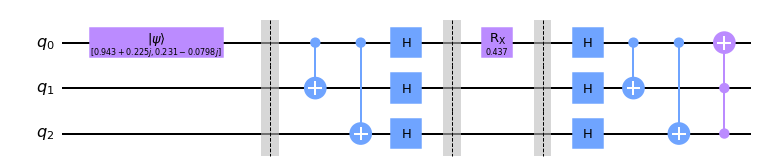

In [8]:
#Part3: hadarmad + cx gate + ccx gate

for ii in range(num_qubits):
    aux1.h(ii) 

for ii in range(num_qubits-1):
    aux1.cx(0,ii+1)

aux1.ccx(2,1,0)

#composing
phase_flip = qc.compose(aux1)

phase_flip.draw('mpl')

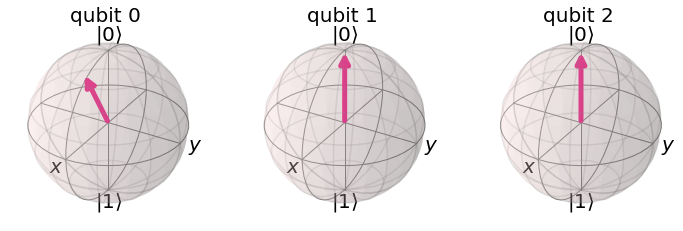

In [9]:
phase_flip.save_statevector()
out_vector1 = sim.run(phase_flip).result().get_statevector()
plot_bloch_multivector(out_vector1)

Note, we have the very state we used to have. 

### Shor Code: bit and phase flip errors

Finally, we consider the the full scenario, where bit and phase flips errors happen. For this purpose, we will implement the Shor code for such error correction. In this case, we need 9 qubits and the bit and phase flips are given by applying the `Rx` and `Rz` gates sequentially. The circuit is

In [10]:
shor_code, aux_shor, aux_shor1 = QuantumCircuit(9), QuantumCircuit(9), QuantumCircuit(9)

#auxiliary circuits
aux_shor.cx(0,3)
aux_shor.cx(0,6) 
aux_shor.h([0,3,6])

ii=0
while ii < 9:
    aux_shor1.cx(ii,ii+1)
    aux_shor1.cx(ii,ii+2)
    ii+=3 

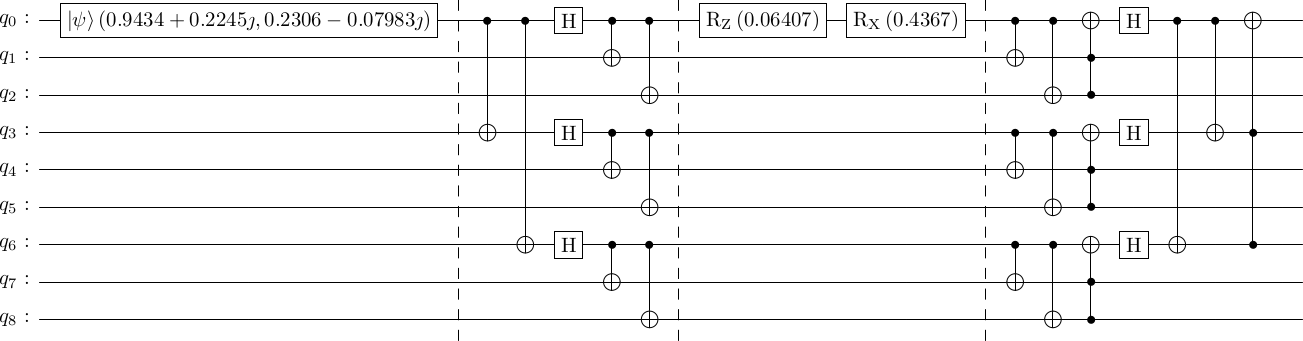

In [11]:
#Part1: Random state for qubit 0
shor_code.append(init_gate, [0])
shor_code.barrier()

#Part2: cx gate + hadarmad
shor_code = shor_code.compose(aux_shor).compose(aux_shor1)
    
#Part3: phase and bit errors with some random angle 
shor_code.barrier()
shor_code.rz(theta, 0)
shor_code.rx(theta1, 0)
shor_code.barrier()

#Part4: cx gate + ccx + hadarmad + ccx
shor_code = shor_code.compose(aux_shor1)

for ii in range(9):
    if ii%3 == 0: 
        shor_code.ccx(ii+2,ii+1,ii)
        
shor_code =  shor_code.compose(aux_shor.inverse())
shor_code.ccx(6,3,0)

shor_code.draw('latex')

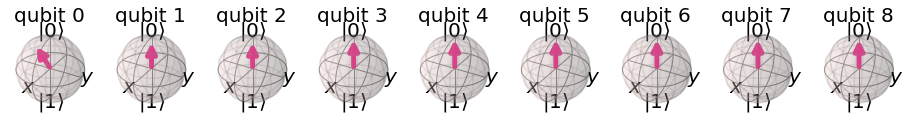

In [12]:
shor_code.save_statevector()
output2 = sim.run(shor_code).result().get_statevector()
plot_bloch_multivector(output2)

Note that in all those cases (in bit and phase flips, and in the Shor code), we restore almost exactly in the qubit 0 the initial state $|\psi\rangle$ which the same generated at the beginning of this tourorial.